# Sumário

Oi Carlos, Debora e Jacson! Obrigado pela oportunidade. Foi um desafio e tanto!

Se tiverem contas no google é só logar. No canto esquerdo em "Upload to session storage" trazer o arquivo "dados.tsv". Daí é só dar o play!

---
> Este notebook refere-se à implementação de um AutoEncoder para extração de features de séries temporais de vendas de uma loja fictícia da Renner.

> Os dados apresentados referem-se ao período de 02/01/2018 até 05/11/2020 e representam o valor total vendido por dia.

> As aplicações são amplas: 

>> Como a missão é o *lifestyle*, então manter uma ampla variedade de looks, produtos e serviços nos ambientes de prestação de serviço (online e presencial) é um grande desafio. Então, se conseguirmos informar ou prever o volume vendido em determinada condição (por UF, Loja, categorias XPTO) poderíamos iniciar planos de ação para garantir ou melhorar a satisfação dos clientes, assim como relacionar com ações de uso e compra de insumos de maneira otimizada. 

>> De maneira mais tangível, elevar o valor investido pelo acionista e garantir a sobrevivência e a prosperidade do negócio (métricas financeiras de análise de investimentos).

>> Outra aplicação poderia ser o uso da informação ou previsão para enriquecer modelos de classificação, clusters, etc...

>> Quem sabe utilizar o modelo para eventos raros/extremos, como uma pandemia ou um evento macroeconômico?

>> Uma grande vantagem das redes neurais profundas é seu comportamento dinâmico e adaptável, o que garante uma certa vantagem sobre indicadores econômicos generalizados.

> Sem mais delongas, vamos lá....

---
> Um AutoEncoder é um tipo de rede neural que modela dados em formato de sequência, tal qual as séries temporais apresentadas neste desafio.

> O AutoEncoder apresentado é um LSTM (Long Short-Term Memory) para uma série temporal univariada ("vendas"). O modelo escolhido foi o Stacked LSTM, o qual tem uma uma camada de entrada, uma camada oculta e uma camada de saída utilizada para fazer a predição. Uma ótima referência é [machinelearningmastery.com](https://machinelearningmastery.com/).

---
> A preparação dos dados foi a divisão em datasets de treino e teste (train, test 20%) e a normalização da escala usando MinMaxScaler (0, 1). O efeito da normalização pode ser visto em...

> Para a rede neural aprender com base no histórico e prever a série temporal foi preciso preparar a amostra usando TimeseriesGenerator. O valor do dia 1 (um) teve como referência os últimos 3 dias (look back), mais um. Assim, sucessivamente, o dia 2, 3, 4, n... O resultado da preparação das amostras pode ser visto...
---

> A rede neural foi configurada com 64 neurônios na primeira camada e na oculta 32, usando a função de ativação 'relu'. O otimizador utilizado para compilar a rede neural foi 'adam', a função de perda 'mse' e a métrica a 'acuracidade' para acompanhar a geração. O número de vezes que o dataset foi utilizado para ajustar o modelo foi 50 (epochs).

> edit: testei várias configurações e acabei parando porque tunar os hyperparâmetros é outra história...isto depende de realizar experimentos e eu parei nos for loops...
---

> O desempenho da solução foi avaliado com o RMSE Root Mean Squared Error sobre todo o período. É uma medida comum utilizada para avaliar o erro médio quadrado (menor melhor). Gostaria de ter feito o RMSE diário, mas não consegui a tempo. Também gostaria de ter avaliado uma média-móvel da variação das vendas diárias e a reconstrução da série.

>> edit: é possível ver os geradores train/test/full_generator. A configuração atual é train_generator para ajustar o modelo. É possível alternar o gerador utilizado para ajustar o modelo.

> O diagnóstico do modelo indica underfitting. A melhoria do modelo pode vir do tunning dos hyperparâmetros: gerador de sequência (TimeseriesGenerator: look_back e batch), assim como, pelo modelo da rede neural escolhida (neurônios, camadas, direção, etc...). 

---

> Em termos de programação, melhorias poderiam ser aplicadas na modularização do código e a definição de funções com docstrings. E claro, estudaria muito mais a fundo o tema, pois o modelo é bem encadeado.

---

Fontes: 

https://blog.mlreview.com/understanding-lstm-and-its-diagrams-37e2f46f1714

https://machinelearningmastery.com/

https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816

# Importando as bibliotecas para realizar a tarefa

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import preprocessing as prep
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from math import sqrt

## Lendo o "dados.tsv" e inspecionando sua estrutura

In [ ]:
filename = "dados.tsv"
df = pd.read_csv(filename, sep="\t", header=0)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sales_day  929 non-null    object 
 1   venda      929 non-null    float64
dtypes: float64(1), object(1)
memory usage: 14.6+ KB
None


## Dividindo o *dataset* em treino e teste em X%

In [ ]:
split_size = 0.2 # changes in here
x_train, x_test, y_train, y_test = train_test_split(df['sales_day'], df['venda'], test_size=split_size, shuffle=False)

## Normalizando os *datasets*

In [ ]:
scaler = prep.MinMaxScaler()
# Scaling y_train
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
# Scaling y_test
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1,1))
# Scaling full dataset
vendas_scaled = scaler.fit_transform(df['venda'].values.reshape(-1,1))

## O efeito da normalização nos *datasets*

In [ ]:
fig = make_subplots(rows=3, cols=1, subplot_titles=("Sales Day Over Time Before Normalization", "Sales Day Over Time After Normalization", "Sales Day Over Time After Normalization"))
fig.add_trace(go.Scatter(x = x_train, y = y_train, mode = 'lines', name = 'Training Dataset'), row=1, col=1)
fig.add_trace(go.Scatter(x = x_test, y = y_test, mode = 'lines', name = 'Test Dataset'), row=1, col=1)
fig.add_trace(go.Scatter(x = x_train, y = y_train_scaled[:, 0], mode = 'lines', name = 'Scaled Training Dataset'), row=2, col=1)
fig.add_trace(go.Scatter(x = x_test, y = y_test_scaled[:, 0], mode = 'lines', name = 'Scaled Test Dataset'), row=2, col=1)
fig.add_trace(go.Scatter(x = df['sales_day'], y = vendas_scaled[:, 0], mode = 'lines', name = 'Scaled Full Dataset'), row=3, col=1)
fig.update_layout(height=1000, width=1100, title_text="The Effect of Normalization in the Datasets")
fig.update_xaxes(title_text = "Period", title_font = {"size": 14}, ticks="outside", nticks=3)
fig.update_yaxes(title_text = "Sales Day", title_font = {"size": 14}, ticks="outside", nticks=7)
fig.show()

# Preparando os *datasets* em amostras de tamanho X utilizando os últimos X dias para supor o próximo dia

In [ ]:
look_back = 3  # how many observations will be used to predict the next day?
batch = 3 # the batch size is the number of samples of size "look_back" that is processed before predicting the next day
train_generator = TimeseriesGenerator(y_train_scaled, y_train_scaled, length=look_back, batch_size=batch)
test_generator = TimeseriesGenerator(y_test_scaled, y_test_scaled, length=look_back, batch_size=1)
full_generator = TimeseriesGenerator(vendas_scaled, vendas_scaled, length=look_back, batch_size=batch)

## Apresentando o que o gerator utilizou como próximo dia

In [ ]:
for i in range(len(train_generator)):
  x, y = train_generator[i]
  print('%s => %s' % (x, y))
  #print(x.shape[0], y.shape[1]) #change here

# Configurando e desenhando o modelo LSTM - Ajustando os *datasets* ao modelo

In [ ]:
# Configure the network 
neurons = 200 # changes in here
num_epochs = 500 # how many times the training set will be used by the learning algorithm. It can be set as fixed or a change (lack of) in model over time

# Design the network
model = Sequential()

## Input
model.add(
    LSTM(neurons,
         activation='relu',
         input_shape=(look_back,1),
         return_sequences=True)
)
## Hidden Layer
model.add(
    LSTM(neurons//2,
         activation='relu',
         input_shape=(look_back,1))
)
## Output Layer
model.add(Dense(1))
## Compiler
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
## Summary of Network Design
model.summary()

# Fitting the model
history = model.fit(train_generator, epochs=num_epochs, verbose=0, batch_size = batch) # silent = 0 validation_data=test_generator

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3, 32)             4352      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


# Fazendo previsões com base no modelo e apresentando

In [ ]:
# Doing the predictions
prediction = model.predict(test_generator, batch_size=look_back)
prediction_full = model.predict(full_generator, batch_size=look_back)

# Turning back de scaling to a proper form
y_train_to_original = scaler.inverse_transform(y_train_scaled)
y_test_to_original = scaler.inverse_transform(y_test_scaled)
prediction_to_original = scaler.inverse_transform(prediction)
prediction_full_to_original = scaler.inverse_transform(prediction_full)

# Showing the results using a line chart
## First chart
fig = make_subplots(rows=2, cols=1, subplot_titles=("Rebulding the Time Series Using the Test Dataset", "Rebulding the Time Series Using the Full Dataset"))
fig.add_trace(go.Scatter(x = x_train, y = y_train_to_original[:,0], mode = 'lines', name = 'Training Dataset'), row=1, col=1)
fig.add_trace(go.Scatter(x = x_test, y = prediction_to_original[:,0], mode = 'lines', name = 'Prediction Over Test'), row=1, col=1)
fig.add_trace(go.Scatter(x = x_test, y = y_test_to_original[:, 0], mode = 'lines', name = 'Test Dataset'), row=1, col=1)
## Second chart
fig.add_trace(go.Scatter(x = df['sales_day'], y = df['venda'], mode = 'lines', name = 'Full Dataset'), row=2, col=1)
fig.add_trace(go.Scatter(x = df['sales_day'], y = prediction_full_to_original[:, 0], mode = 'lines', name = 'Prediction Over Full'), row=2, col=1)
## Settings and Go!
fig.update_layout(height=800, width=1100, title_text="Predicting Over The Dataset")
fig.update_xaxes(title_text = "Period", title_font = {"size": 14}, ticks="outside", nticks=3)
fig.update_yaxes(title_text = "Sales Day", title_font = {"size": 14}, ticks="outside", nticks=7)
fig.show()

# Diagnóstico do modelo

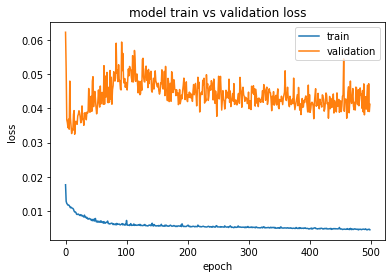

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Métrica de desempenho

In [ ]:
rmse = sqrt(mean_squared_error(y_test_scaled[look_back:], prediction))
print(rmse)

0.20297497091468003


## Minha tentativa de fazer o RMSE por dia
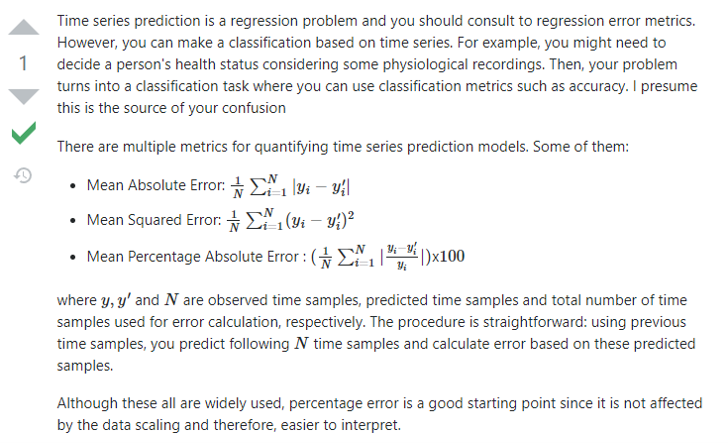

In [ ]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
 
score, scores = evaluate_forecasts(y_test_scaled[look_back:], prediction)
summarize_scores(history, score, scores)

<keras.callbacks.History object at 0x7f466d682950>: [0.203] 0.2


# Fazendo previsões para os próximos 30 dias e apresentando

In [ ]:
# Doing predictions
def predict(num_prediction, model):
    prediction_list = y_test_scaled[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['sales_day'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_to_original = scaler.inverse_transform(forecast.reshape(-1,1))
forecast_dates = predict_dates(num_prediction)

# Showing in a line chart
trace1 = go.Scatter(
    x = df['sales_day'].tolist(),
    y = df['venda'].tolist(),
    mode = 'lines',
    name = 'Sales Day'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast_to_original[:, 0],
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Forecast - Sales Day Over Time",
    xaxis = {'title' : "Period"},
    yaxis = {'title' : "Sales Day"}
)

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()